In [38]:
using MAT
using NPZ
using Glob
using WebIO
using PyPlot
using Eirene
using Random
using Clustering

rng = MersenneTwister(1337);

#### Load data

In [39]:
filelist = glob("EGF(E6)w*.mat", "experimental-data")
sz = size(filelist)[1];

well_nums = []
particle_pos = []

for i in 1:sz
    
    filenamewext = split(filelist[i], '/')[2]
    filename = split(filenamewext, '.')[1]
    well_num = parse(Int, split(filename, 'w')[2])
    
    mat_variables = matread(filelist[i])
    pos_x = mat_variables["storeX"]
    pos_y = mat_variables["storeY"]
    pos_x_final = pos_x[1:end, size(pos_x)[2]]
    pos_y_final = pos_y[1:end, size(pos_y)[2]]
    pos_x_final = filter!(!(isnan), pos_x_final)
    pos_y_final = filter!(!(isnan), pos_y_final)
    pos_final = hcat(pos_x_final, pos_y_final)
    pos_final = transpose(pos_final)
    
    push!(well_nums, well_num)
    push!(particle_pos, pos_final)
    
end

#### Sort by well number

In [40]:
sort_idx = sortperm(well_nums)
well_nums = well_nums[sort_idx];
particle_pos = particle_pos[sort_idx];

densities = [500, 500, 500, 1000, 1000, 1000, 
             1000, 1000, 1000, 500, 500, 500,
             500, 500, 500, 1000, 1000, 1000,
             1000, 1000, 1000, 500, 500, 500];

conditions = ["GM", "Gefitinib", "Assay", "GM", "Gefitinib", "Assay",
             "Assay", "Gefitinib", "GM", "Assay", "Gefitinib", "GM",
             "GM", "Gefitinib", "Assay", "GM", "Gefitinib", "Assay",
             "Assay", "Gefitinib", "GM", "Assay", "Gefitinib", "GM"];

#### Plot

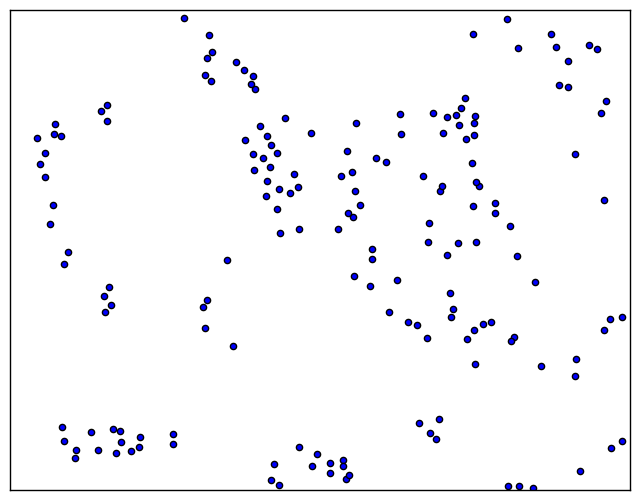

Well 67 Assay 1000 cells
Number of cells 171

(Any[], Any[])

In [37]:
cnt = 19
print("Well " * string(well_nums[cnt]) * " " * conditions[cnt] * " " * string(densities[cnt]) * " cells\n")
print("Number of cells " * string(size(particle_pos[cnt])[2]))
scatter(particle_pos[cnt][1,:],particle_pos[cnt][2,:])
xticks([])
xlim([0, 900])
ylim([0, 900])
yticks([])

#### Compute change in Wasserstein distance with random particle removal

In [109]:
num_removals = 100
wasserstein_distances = Array{Float64}(undef, length(well_nums), num_removals);

for cnt in 1:length(well_nums)
    
    well_num = well_nums[cnt]
    condition = conditions[cnt]
    density = densities[cnt]
    num_cells = size(particle_pos[cnt])[2]
    label_string = "Well " * string(well_num) * " (" * condition * ", " * string(density) * " cells)"
    
    if density == 1000
        print("Skipping: " * label_string * ", Num Cells: " * string(num_cells) * "\n")
        continue
    else
        print("Computing: " * label_string * ", Num Cells: " * string(num_cells) * "\n")
    end
    
    ref_pers_diag = eirene(particle_pos[cnt], model="pc", maxdim=1)
    ref_barcode = barcode(ref_pers_diag)
    
    for i in 1:num_removals
       
        permutation = randperm(rng, num_cells)
        keep_idx = permutation[1:(num_cells-i)]
        pos_tmp = particle_pos[cnt][:,keep_idx]
        pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
        barcode_tmp = barcode(pers_diag_tmp)
        wasserstein_distances[cnt, i] = wasserstein_distance(barcode_tmp, ref_barcode, q=2, p=2)
        
    end
    
end

Computing: Well 1 (GM, 500 cells), Num Cells: 391
Computing: Well 2 (Gefitinib, 500 cells), Num Cells: 320
Computing: Well 3 (Assay, 500 cells), Num Cells: 176
Skipping: Well 4 (GM, 1000 cells), Num Cells: 947
Skipping: Well 5 (Gefitinib, 1000 cells), Num Cells: 451
Skipping: Well 6 (Assay, 1000 cells), Num Cells: 228
Skipping: Well 19 (Assay, 1000 cells), Num Cells: 284
Skipping: Well 20 (Gefitinib, 1000 cells), Num Cells: 537
Skipping: Well 21 (GM, 1000 cells), Num Cells: 872
Computing: Well 22 (Assay, 500 cells), Num Cells: 116
Computing: Well 23 (Gefitinib, 500 cells), Num Cells: 268
Computing: Well 24 (GM, 500 cells), Num Cells: 438
Computing: Well 49 (GM, 500 cells), Num Cells: 185
Computing: Well 50 (Gefitinib, 500 cells), Num Cells: 139
Computing: Well 51 (Assay, 500 cells), Num Cells: 157
Skipping: Well 52 (GM, 1000 cells), Num Cells: 619
Skipping: Well 53 (Gefitinib, 1000 cells), Num Cells: 349
Skipping: Well 54 (Assay, 1000 cells), Num Cells: 275
Skipping: Well 67 (Assay, 10

In [110]:
npzwrite("Exp_Wasserstein_Removal.npy", wasserstein_distances)

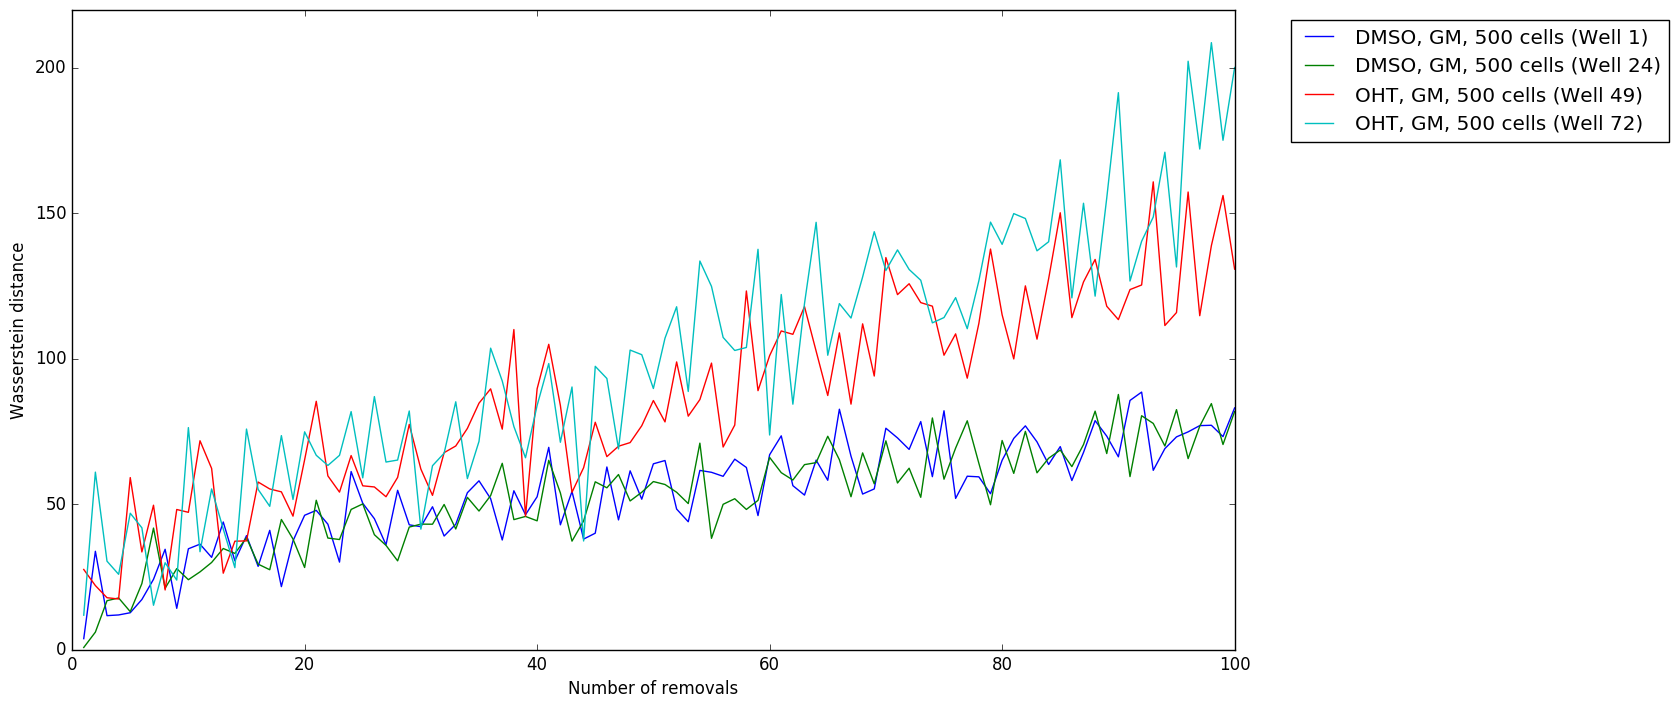

In [91]:
figure(figsize=(15,8))

for cnt in 1:length(well_nums)
    well_num = well_nums[cnt]
    condition = conditions[cnt]
    density = densities[cnt]
    
    if density == 1000
        continue
    end
    
    if condition != "GM"
        continue
    end
    
    num_cells = size(particle_pos[cnt])[2]
    
    label_string = ""
    if well_num < 25
        label_string = "DMSO, "
    else
        label_string = "OHT, "
    end
    
    label_string = label_string * condition * ", " * string(density) * " cells " * "(Well " * string(well_num) * ")"
    plot(1:num_removals, wasserstein_distances[cnt,:], label=label_string)
end

xlabel("Number of removals")
ylabel("Wasserstein distance")
ylim([0, 220])
legend(bbox_to_anchor=(1.04,1),loc = "upper left");

#### Compute peristence diagrams and barcodes

In [48]:
@time begin

    barcodes = []

    for i in 1:sz
        pers_diag = eirene(particle_pos[i], model="pc", maxdim=1)
        push!(barcodes, barcode(pers_diag))
    end
    
end

 46.776207 seconds (135.74 M allocations: 28.295 GiB, 10.63% gc time)


#### Compute pairwise Wasserstein distances

In [49]:
@time begin
    
    wassmatrix = Array{Float64}(undef, sz, sz);
    for rows in 1:sz
        for cols in 1:sz
            wassmatrix[rows, cols] = wasserstein_distance(barcodes[rows], barcodes[cols], q=2, p=2);
        end
    end
    
end

 77.979330 seconds (532.90 k allocations: 718.178 MiB, 0.05% gc time)


In [50]:
npzwrite("Exp_Wasserstein_Pairwise.npy", wassmatrix)

In [66]:
well_names = []

for i in 1:sz
    treat = ""
    if well_nums[i] < 25
        treat = treat * "DMSO, "
    else
        treat = treat * "OHT, "
    end
    push!(well_names, treat * conditions[i] * ", " * string(densities[i]) * " cells")
end

#### Plot heatmap

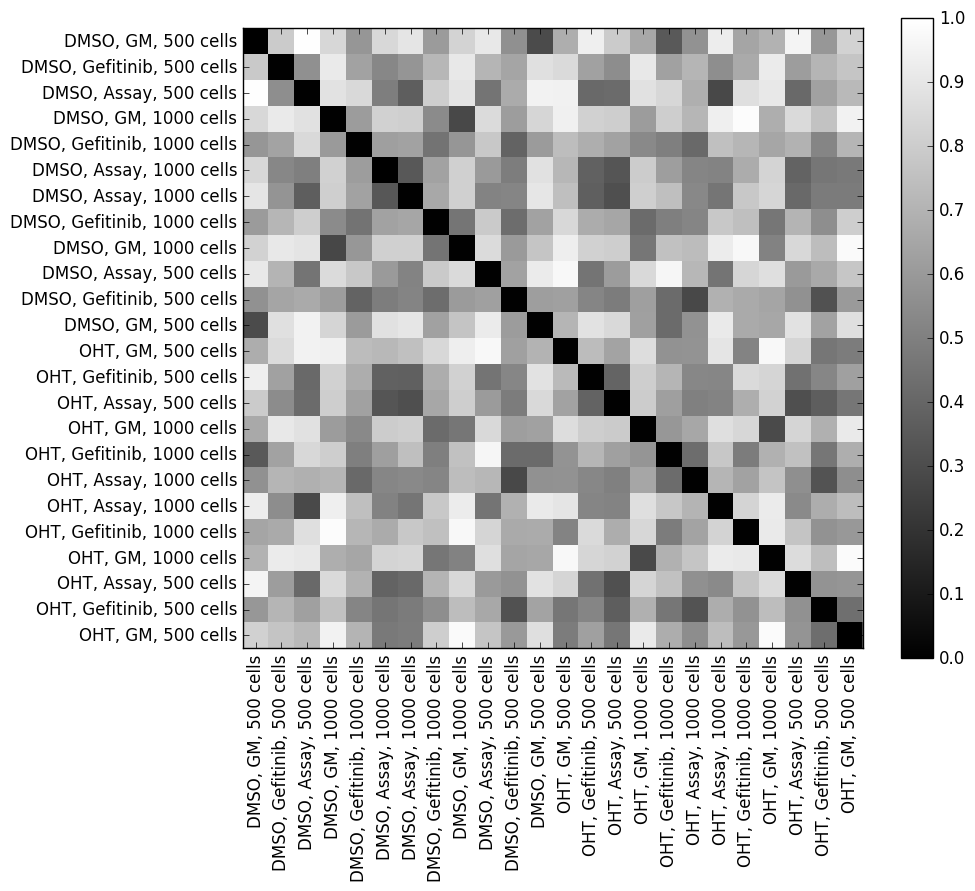

In [67]:
max_coord = maximum(wassmatrix)
wassmatrix = wassmatrix/max_coord

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:sz-1, well_names, rotation=90);
yticks(0:sz-1, well_names);
colorbar();

In [53]:
hclust_res = hclust(wassmatrix, linkage=:complete, uplo=:U)

Hclust{Float64}([-4 -9; -11 -18; … ; 16 20; 21 22], [0.27958415142874804, 0.2820108087713452, 0.2829332618749553, 0.29240442690326, 0.29416293531431004, 0.3107445965920265, 0.3269746528082269, 0.34563248612028385, 0.383417455189077, 0.4202750506505168  …  0.48683567578941195, 0.5555333224589709, 0.5974192565562002, 0.6100879856119937, 0.6427495058542566, 0.6798061137405187, 0.7099598189959678, 0.8451843285001054, 0.9765418641278918, 1.0], [17, 1, 12, 23, 11, 18, 5, 8, 4, 9  …  24, 2, 15, 22, 14, 6, 7, 10, 3, 19], :complete)

In [55]:
npzwrite("wasserstein_matrix_exp.npz", Dict("wassmatrix" => wassmatrix, "densities" => densities, 
        "well_nums" => convert(Array{Int64, 1}, well_nums)))

In [61]:
dendrogram_label_order = hclust_res.order;
print(dendrogram_label_order)